<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_10_manifold_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.



*   multidimensional scaling (MDS)
*   locally linear embedding (LLE)
*   isometric mapping (Isomap)



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Manifold Learning: “HELLO”

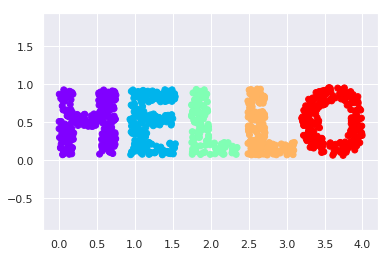

In [0]:
# generate data for further usage

def make_hello(N=1000, rseed=42):
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

#Multidimensional Scaling (MDS)

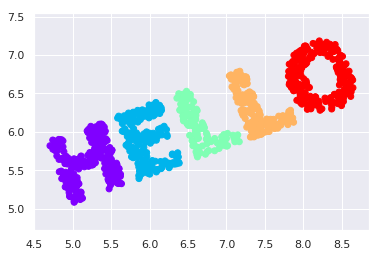

In [0]:
def rotate(X, angle):
  theta = np.deg2rad(angle)
  R = [[np.cos(theta), np.sin(theta)],
       [-np.sin(theta), np.cos(theta)]]
  return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [0]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape
# matrix of pairwise distances between points

(1000, 1000)

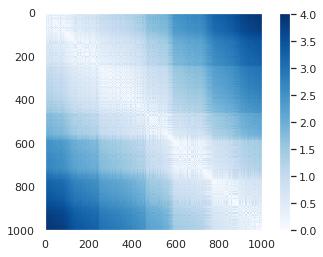

In [0]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [0]:
# rotated mage gives rise to similar matrix
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

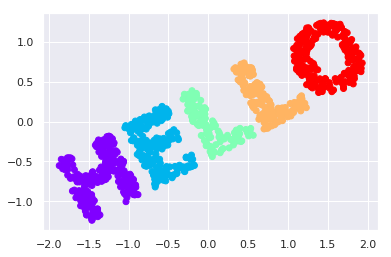

In [0]:
# recover D-dim representation by given distance matrix
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

#MDS as Manifold Learning

In [0]:
# this method works for _ANY_ dimension
# let's try 3D
def random_projection(X, dimension=3, rseed=42):
  assert dimension >= X.shape[1]
  rng = np.random.RandomState(rseed)
  C = rng.randn(dimension, dimension)
  e, V = np.linalg.eigh(np.dot(C, C.T))
  return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

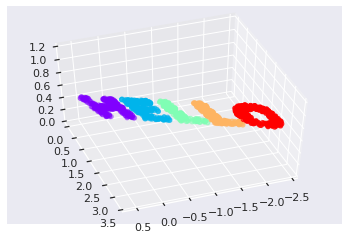

In [0]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=70, elev=50)

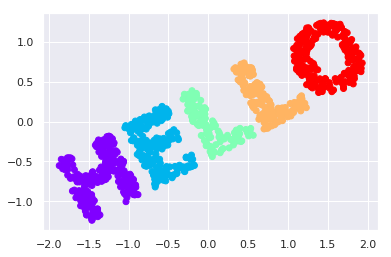

In [0]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

#Nonlinear Embeddings: Where MDS Fails

In [0]:
# arrange "hello" in non-linear, S-shaped way
def make_hello_s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T
XS = make_hello_s_curve(X)

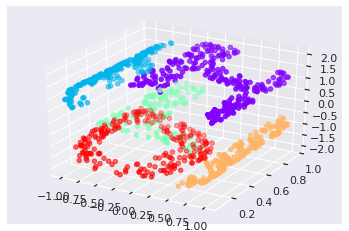

In [0]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

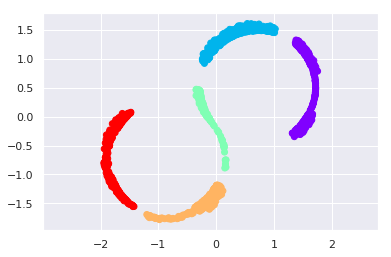

In [0]:
# MDS fails
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');
# does not unwrap the S-curve, but instead throws out the original y-axis

#Nonlinear Manifolds: Locally Linear Embedding

Possible solution may be to not preserve distances between faraway points but only between nearby points

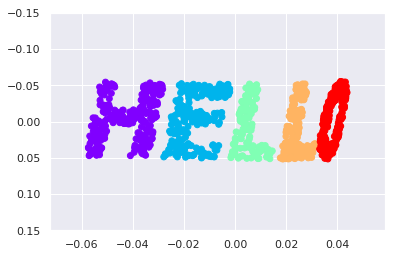

In [0]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

#Some Thoughts on Manifold Methods

**Problems:**
 *  In manifold learning, there is no good framework for handling missing data. 
 In contrast, there are straightforward iterative approaches for missing data in PCA.
 *  In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding.
 In contrast, PCA naturally filters noise from the most important components.
 *  The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors.
 In contrast, PCA does not involve such a choice.
 *  In manifold learning, the globally optimal number of output dimensions is difficult to determine.
 In contrast, PCA lets you find the output dimension based on the explained variance.
 *  In manifold learning, the meaning of the embedded dimensions is not always clear.
 In PCA, the principal components have a very clear meaning.
 *  In manifold learning the computational expense of manifold methods scales as $O(N^2)$ or $O(N^3)$.
For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

#Example: Isomap on Faces

In [0]:
# set of images with 1,000 pixels 
# each can be thought of as collection of points in 1,000 dimensions
# the brightness of each pixel in each image defines the coordinate in that dimension.

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

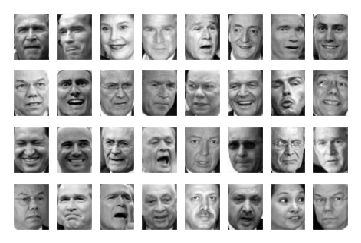

In [0]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  axi.imshow(faces.images[i], cmap='gray')

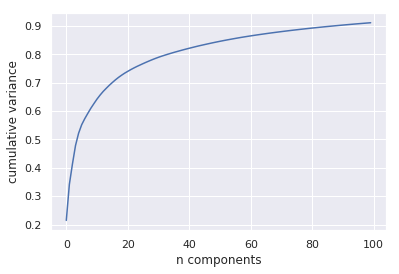

In [0]:
# explore with PCA how many components are needed

from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data) # big dataset, use randomized solver
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

# nearly 100 components are required to preserve 90% of the variance

In [0]:
# LLE or Isomap can be helpful

from sklearn.manifold import Isomap
model = Isomap(n_components = 2)
proj = model.fit_transform(faces.data)
proj.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


(2370, 2)

In [0]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
  ax = ax or plt.gca()
  proj = model.fit_transform(data)
  ax.plot(proj[:, 0], proj[:, 1], '.k')
  if images is not None:
    min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
    shown_images = np.array([2 * proj.max(0)])
    for i in range(data.shape[0]):
      dist = np.sum((proj[i] - shown_images) ** 2, 1)
      if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
      shown_images = np.vstack([shown_images, proj[i]])
      imagebox = offsetbox.AnnotationBbox(
      offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
      ax.add_artist(imagebox)

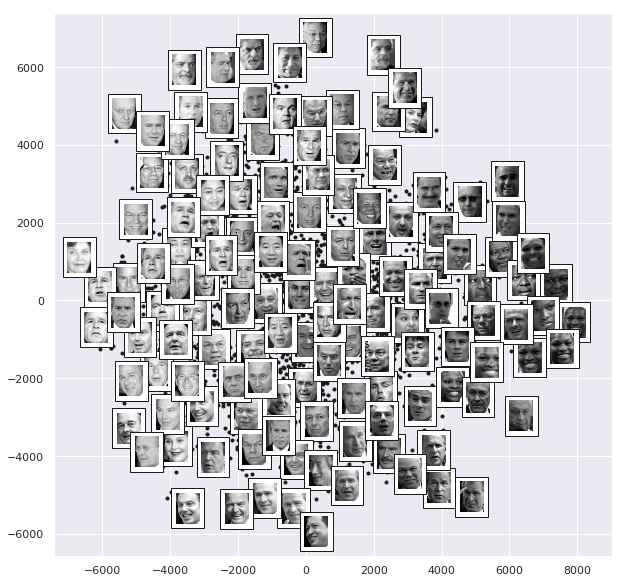

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2])

#Example: Visualizing Structure in Digits

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

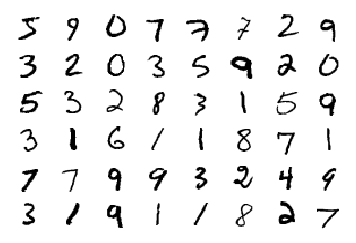

In [0]:
# plot few first
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

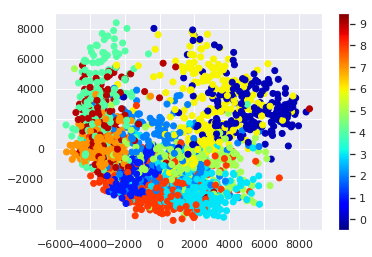

In [0]:
import matplotlib.cm as cm

# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]
model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], cmap=cm.jet, c=target.astype(int))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

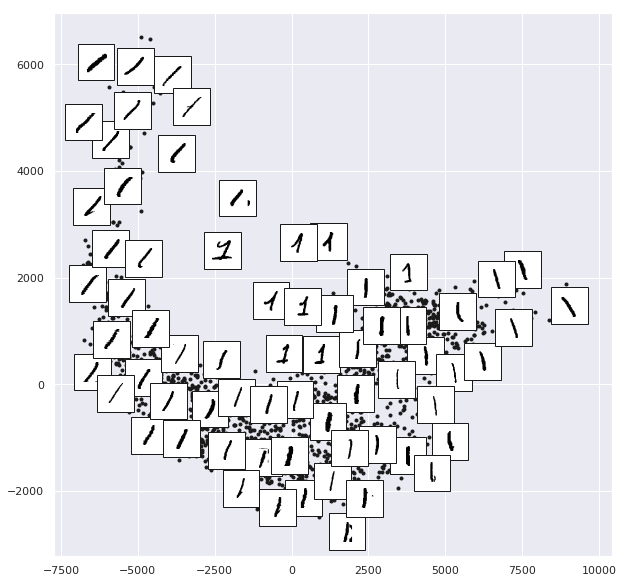

In [0]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target.astype(int) == 1][::4]
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)), ax=ax, thumb_frac=0.05, cmap='gray_r')

may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline

#Test area

In [0]:
# positive samples
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [0]:
# negative samples
from skimage import data, color, feature
from skimage import data, transform
import numpy as np

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 500, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(15000, 62, 47)

In [0]:
# collect dataset
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape

(28233, 1215)

In [0]:
# Grid search for best parameters
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

#from sklearn.svm import SVC
#model = SVC(kernel='rbf', C=1E1, gamma='auto')
#model.fit(X_train, y_train)

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
model = grid.best_estimator_
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9863280558212021
{'C': 1.0}


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


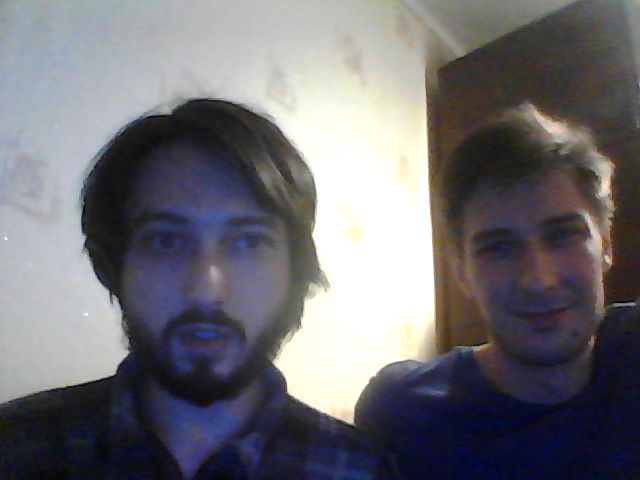

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


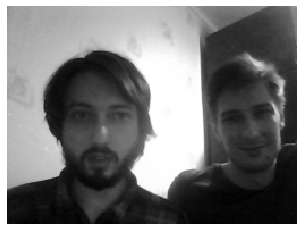

(7523, 1215)
313.0


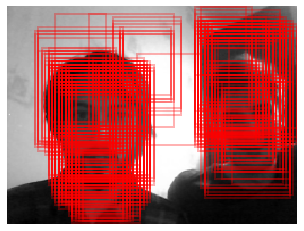

In [0]:
import skimage.data
import matplotlib.pyplot as plt

import imageio
test_image = imageio.imread("photo.jpg", pilmode='F')


#test_image = skimage.data.astronaut()
#test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.4)
#test_image = test_image[:160, 40:180]

#print(test_image[:10,:10])

plt.imshow(test_image, cmap='gray')
plt.axis('off');
plt.show()

def sliding_window(img):
  size = positive_patches[0].shape
  istep, jstep = 3, 3
  for Nx in [60, 80, 100]:
    Ny = int(size[1] / size[0] * Nx)
    for i in range(0, img.shape[0] - Nx, istep):
      for j in range(0, img.shape[1] - Ny, jstep):
        yield (i, j, Ny, Nx), transform.resize(img[i:i + Nx, j:j + Ny], size)
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
print(patches_hog.shape)

labels = model.predict(patches_hog)
print(labels.sum())

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

indices = np.array(indices)

for i, j, w, h in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), w, h, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [0]:
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz

In [0]:
!tar zxvf FDDB-folds.tgz
!tar zxvf originalPics.tar.gz

In [0]:
!cat FDDB-folds/FDDB-fold-01-ellipseList.txt

In [0]:
!rm -rf ./lfwcrop_grey

In [1]:
# GET NEW DATASETS
!wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
!unzip lfwcrop_grey.zip > /dev/null
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
!tar zxvf stl10_binary.tar.gz

import re
import numpy

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

import numpy as np
def img_to_arr(path):
  image = read_pgm("./lfwcrop_grey/faces/Vicente_Fox_0015.pgm", byteorder='<')
  arr = image / np.sum(image)
  return arr


from matplotlib import pyplot
import glob

def load_and_conv_faces():
  files = [f for f in glob.glob("./lfwcrop_grey/**/*.pgm", recursive=True)]
  list_faces = []
  for f in files:
    list_faces.append(img_to_arr(f))
  np.save('faces', np.array(list_faces), allow_pickle=False)

load_and_conv_faces()

def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images


from PIL import Image
def conv_im(img):
  img = Image.fromarray(img, 'RGB')
  img = img.resize((64, 64))
  img = img.convert(mode='L')
  a = np.array(img)
  return a / np.sum(a)


def load_and_conv_other():
  arr = read_all_images("stl10_binary/unlabeled_X.bin")
  lst_imgs = [conv_im(arr[idx]) for idx in range(0, 100000, 5)]
  np.save('not_faces', np.array(lst_imgs), allow_pickle=False)

load_and_conv_other()

!rm -rf ./lfwcrop_grey
!rm -rf ./stl10_binary
!rm lfwcrop_grey.zip
!rm stl10_binary.tar.gz

--2019-11-14 19:53:13--  http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
Resolving conradsanderson.id.au (conradsanderson.id.au)... 103.18.109.184, 2407:e700:2:13::e0
Connecting to conradsanderson.id.au (conradsanderson.id.au)|103.18.109.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51132813 (49M) [application/zip]
Saving to: ‘lfwcrop_grey.zip’

lfwcrop_grey.zip    100%[===================>]  48.76M  11.5MB/s    in 4.8s    

2019-11-14 19:53:18 (10.1 MB/s) - ‘lfwcrop_grey.zip’ saved [51132813/51132813]

--2019-11-14 19:53:22--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  23.2MB/s    in 2m 3s   

2019-11-14 19:55:26 (20

In [60]:
def load():
  faces = np.load('faces.npy')
  not_faces = np.load('not_faces.npy')
  print(faces.shape, not_faces.shape)
  return np.concatenate((faces, not_faces), axis=0)

all_data = load()

from skimage import feature
all_features = np.array([feature.hog(img, multichannel=False) for img in all_data])

from sklearn.manifold import Isomap
model = Isomap(n_components=5)
model.fit(all_features[::10])

(13233, 64, 64) (20000, 64, 64)


Isomap(eigen_solver='auto', max_iter=None, n_components=5, n_jobs=None,
       n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

In [61]:
projected = model.transform(all_features[1::10])
y = np.concatenate([np.zeros(13233), np.ones(20000)])
y = y[1::10]
y.shape, projected.shape

((3324,), (3324, 5))

In [64]:
from sklearn.svm import SVC # "Support vector classifier"

model_svm = SVC(kernel='rbf', C=1E5, gamma='auto')
model_svm.fit(projected, y)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning:

The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.



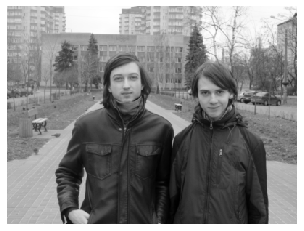

(12360, 2916)
12359.0


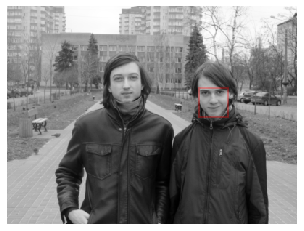

In [73]:
import skimage.data
import matplotlib.pyplot as plt
from skimage import data, transform

import imageio
test_image = imageio.imread("IMG_3429.JPG", pilmode='F')


#test_image = skimage.data.astronaut()
#test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 300.0 / test_image.shape[0])
#test_image = test_image[:160, 40:180]

#print(test_image[:10,:10])

plt.imshow(test_image, cmap='gray')
plt.axis('off');
plt.show()

def sliding_window(img):
  size = [64, 64]
  for Nx in [20, 30, 40, 50, 64]:
    Ny = int(size[1] / size[0] * Nx)
    istep, jstep = int(Nx / 5), int(Ny / 5)
    for i in range(0, img.shape[0] - Nx, istep):
      for j in range(0, img.shape[1] - Ny, jstep):
        new_img = transform.resize(img[i:i + Nx, j:j + Ny], size)
        # division changes result
        yield (i, j, Ny, Nx), new_img / np.sum(new_img)
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
print(patches_hog.shape)
features = model.transform(patches_hog)

labels = model_svm.predict(features)
print(labels.sum())

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

indices = np.array(indices)

for i, j, w, h in indices[labels == 0]:
    ax.add_patch(plt.Rectangle((j, i), w, h, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [71]:
test_image.shape

(1382, 1843)